In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
!pip install -U accelerate
!pip install -U transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate
from transformers import AutoTokenizer
import evaluate
import torch
from PIL import Image
import matplotlib.pyplot as plt

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("SHIRSH_HUGGINGFACE_API_KEY")

from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # Set to 'false' if needed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 34.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
  Preparing metadata (setup.py) ... - \ done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=d3f4b6d1a1ac97a3fb5bfaf85945735d9b04f4c1723d28e630f038817ff9a44b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.4 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Importing Text Data

In [2]:
# text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|')
# text_data

# Data Preparation

#### Flickr8k Data

In [3]:
# text_data = pd.read_csv('/kaggle/input/flickr8k/captions.txt', sep='|' )
# text_data.rename(columns={"caption_number":"image_repeat","caption_text":"caption"},inplace=True)
# text_data.drop(text_data[text_data['image_name']=="2258277193_586949ec62.jpg.1"].index, inplace=True)
# text_data.reset_index(drop=True, inplace=True)

In [4]:
# # Drop rows with given value of column
# text_data_train = text_data.drop(text_data[text_data['image_repeat']==0].index)
# text_data_train.reset_index(drop=True, inplace=True)

# # text_data_train = text_data[text_data['image_repeat']==1]
# # text_data_train.reset_index(drop=True, inplace=True)
# text_data_val = text_data[ text_data['image_repeat']==0 ]
# text_data_val.reset_index(drop=True, inplace=True)
# text_data_train.shape, text_data_val.shape

#### Google Conceptual Captioning Data

In [5]:
from datasets import Dataset, load_dataset
 
dataset = load_dataset("shirsh10mall/Image_Captioning_Dataset", streaming=False)

dataset = dataset.filter(lambda instance, index: instance["drop_this_row"] == "no" and index<55000 , with_indices=True) # ( index<1400 or index>1500 ) and ( index<20000 or index>23000 ) and
dataset = dataset.remove_columns(["drop_this_row","image_url"])
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/shirsh10mall--Image_Captioning_Dataset-104135c265698044/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['caption', 'image_data'],
        num_rows: 45413
    })
})

In [6]:
# yo_dataset = ImageCaptionDataset(dataset["train"], decoder_tokenizer, max_length)
# yo_dataloader = DataLoader(yo_dataset, batch_size=batch_size, shuffle=False) #  prefetch_factor=2, num_workers=2, pin_memory=True, drop_last=True

# for batch in tqdm(yo_dataloader):
#     if batch==-1:
#         print("yo")

In [7]:
dataset = dataset["train"].train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['caption', 'image_data'],
        num_rows: 40871
    })
    test: Dataset({
        features: ['caption', 'image_data'],
        num_rows: 4542
    })
})

# Vision Encoder Decoder Models

In [8]:
batch_size = 16
epochs = 20

In [9]:
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel, AutoModel
from PIL import Image
import requests

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", add_special_tokens=True)

if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/input/image-captioning-fine-tune-vit-bert-model-flickr8k/Image_Captioning_Fine_Tune_ViT_BERT_model_flickr8k")

# ids
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

#### Flickr8k Data

In [10]:
# from torch.utils.data import Dataset
# # from datasets import Dataset
# image_height = 224
# image_width = 224

# class ImageCaptionDataset(Dataset):
#     def __init__(self, image_path, text_df, tokenizer, image_height,image_width):
#         self.image_path = image_path
#         self.text_df = text_df
#         self.tokenizer = tokenizer
#         self.image_height = image_height
#         self.image_width = image_width
        
#     def __len__(self):
#         return self.text_df.shape[0]
    
#     def __getitem__(self,index):
#         path_filename = self.image_path + text_data_train.iloc[index]['image_name']
#         image = np.array(Image.open( path_filename ).resize((self.image_width, self.image_height)), dtype=np.uint8)
#         image = torch.tensor(np.moveaxis(image, -1, 0))
#         caption_token = self.tokenizer( text_data_train.iloc[index]['caption'], add_special_tokens=True, padding="max_length", max_length=32, truncation = True  ).input_ids 
#         caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token] 
#         return {"pixel_values": image.squeeze(), "caption_token": torch.tensor(caption_token)} #, "caption":self.captions[index]}


# train_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_train , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )
# val_dataset = ImageCaptionDataset( image_path="/kaggle/input/flickr8k/images/", text_df=text_data_val , tokenizer=decoder_tokenizer, image_height=224, image_width=224 )

#### Google Conceptual Captioning Data

In [11]:
max_length = 32

from torchvision import transforms

# Define your dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=64):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transforms.Compose([   transforms.Resize((224,224)) ,  # Resize the PIL image
                                                transforms.ToTensor()  # Convert the PIL image back to tensor
                                            ])
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        instance = self.dataset[idx]
        image = instance["image_data"]
        image = self.transform( image )
        channels = image.shape[0]
        if channels==1:
            image = torch.stack( [image]*3 , dim=1)
        elif channels==4:
            image = image[:3, :, :]
            
        # image = processor(images=image, return_tensors="pt").pixel_values
        
        caption = instance["caption"]
                
        text_inputs = self.tokenizer(caption, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        input_ids = [token if token != self.tokenizer.pad_token_id else -100 for token in text_inputs['input_ids'][0]] 
        return { 'pixel_values': image.squeeze(), 'input_ids': torch.tensor(input_ids).squeeze() }

    
from torch.utils.data import DataLoader

train_dataset = ImageCaptionDataset(dataset["train"], decoder_tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # prefetch_factor=2, num_workers=2, pin_memory=True, drop_last=True

val_dataset = ImageCaptionDataset(dataset["test"], decoder_tokenizer, max_length)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # , prefetch_factor=2, num_workers=2, pin_memory=True, drop_last=True

In [12]:
i = 2
train_dataset.__getitem__(i)["pixel_values"].shape, train_dataset.__getitem__(i)["input_ids"].shape

(torch.Size([3, 224, 224]), torch.Size([32]))

# Display few images

In [13]:
# # Display fews images
# plt.figure(figsize=(10,10))
# for i in range(16):
#     plt.subplot(4,4,i+1)
#     plt.imshow(np.moveaxis(train_dataset.__getitem__(i)['pixel_values'].numpy(), 0, -1))
#     plt.axis('off')
#     # caption (small font size)
#     caption = []
#     for word in decoder_tokenizer.decode( [0 if token==-100 else token for token in train_dataset.__getitem__(i)['input_ids'].numpy()] ).split():
#         if word not in decoder_tokenizer.all_special_tokens:
#             caption.append(word)
#     caption = " ".join(caption)
#     plt.text(0, 2, caption, fontsize=20)
#     # largen plot size
#     plt.gcf().set_size_inches(40, 30)
    
# plt.show()

# Training Setup

In [14]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
num_training_steps = epochs * len(train_dataloader)
# lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/10), num_training_steps=num_training_steps )
lr_scheduler = None

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)
# Set GPU/CPU
model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# Training Model

In [15]:
print("yo")

yo


In [16]:
from tqdm.auto import tqdm

progress_bar = tqdm(total=num_training_steps, desc='Training Progress')

num_batches = len(train_dataloader)
print_step = 5

batch_counter = 0
model.train()
for epoch in range(epochs):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        losses.append(loss.item())
        
        if batch_counter % print_step == 0:
            temp_avg_loss = sum(losses) / len(losses)
            print( "Epoch: ", epoch+1, " | batch: ", batch_counter, "/", num_batches , " | Loss: ", temp_avg_loss )
            
        batch_counter = batch_counter + 1

    avg_loss = sum(losses) / len(losses)
    progress_bar.set_postfix({'Avg Loss': avg_loss}, refresh=True)
    print('Epoch: {}, Avg Loss: {:.4f}'.format(epoch + 1, avg_loss))

progress_bar.close()  # Close the progress bar after training completes

Training Progress:   0%|          | 0/51100 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch:  1  | batch:  0 / 2555  | Loss:  7.3681840896606445
Epoch:  1  | batch:  5 / 2555  | Loss:  6.973897695541382
Epoch:  1  | batch:  10 / 2555  | Loss:  6.747437217018821
Epoch:  1  | batch:  15 / 2555  | Loss:  6.563769638538361
Epoch:  1  | batch:  20 / 2555  | Loss:  6.300222987220401
Epoch:  1  | batch:  25 / 2555  | Loss:  6.1019050891582785
Epoch:  1  | batch:  30 / 2555  | Loss:  5.9501785462902435
Epoch:  1  | batch:  35 / 2555  | Loss:  5.820083181063334
Epoch:  1  | batch:  40 / 2555  | Loss:  5.736489319219822
Epoch:  1  | batch:  45 / 2555  | Loss:  5.64037969838018
Epoch:  1  | batch:  50 / 2555  | Loss:  5.561046862134747
Epoch:  1  | batch:  55 / 2555  | Loss:  5.491979820387704
Epoch:  1  | batch:  60 / 2555  | Loss:  5.43604745239508
Epoch:  1  | batch:  65 / 2555  | Loss:  5.372868689623746
Epoch:  1  | batch:  70 / 2555  | Loss:  5.33447467777091
Epoch:  1  | batch:  75 / 2555  | Loss:  5.292510685167815
Epoch:  1  | batch:  80 / 2555  | Loss:  5.256731833940671

# Saving Model

In [17]:
# # Saving the model, including its configuration
# model.save_pretrained("Image_Captioning_Fine_Tune_ViT_BERT_model_flickr8k")

model.push_to_hub( "shirsh10mall/Image_Captioning_FineTune_ViT_BERT_GCC", use_auth_token=secret_value, 
                        commit_message="Image_Captioning_model_training_epochs"+str(epochs)+"_datapoint"+str(len(train_dataset)) )

/opt/conda/lib/python3.10/site-packages/transformers/utils/hub.py:831: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/897M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shirsh10mall/Image_Captioning_FineTune_ViT_BERT_GCC/commit/df21a93cdd7f5034aec7f6bfed9ab240d259ffbd', commit_message='Image_Captioning_model_training_epochs20_datapoint40871', commit_description='', oid='df21a93cdd7f5034aec7f6bfed9ab240d259ffbd', pr_url=None, pr_revision=None, pr_num=None)

# Evaluating Model

In [18]:
metric = evaluate.load('rouge')

model.eval()
losses = []
i = 0
for batch in tqdm(train_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['input_ids'])

    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['input_ids'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
train_rouge_score = metric.compute()
print( " Train Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Train Set: ", train_rouge_score )

  0%|          | 0/2555 [00:00<?, ?it/s]

 Train Loss:  tensor(91.6372)
 Rouge Score on Train Set:  {'rouge1': 0.36710897042050294, 'rouge2': 0.33816313901067674, 'rougeL': 0.36667383156108774, 'rougeLsum': 0.36674022686714125}


In [19]:
metric = evaluate.load('rouge')

model.eval()
losses = []
for batch in tqdm(val_dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'],labels=batch['input_ids'])
    
    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)
    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions,skip_special_tokens=True)
    predictions = [ pred_sen.replace(".","") for pred_sen in predictions ]
    references = [decoder_tokenizer.decode( [0 if token ==-100 else token for token in ref ] ) for ref in batch['input_ids'].tolist() ]
    metric.add_batch( predictions=predictions, references=references )
    
val_rouge_score = metric.compute()
print( " Validation Loss: ", torch.sum(torch.tensor(losses)) )
print(" Rouge Score on Validation Set: ", val_rouge_score )

  0%|          | 0/284 [00:00<?, ?it/s]

 Validation Loss:  tensor(1077.0847)
 Rouge Score on Validation Set:  {'rouge1': 0.2109869788982799, 'rouge2': 0.1442993674748479, 'rougeL': 0.20270110326014618, 'rougeLsum': 0.2029011010230024}


# Generating Captions

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1411: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


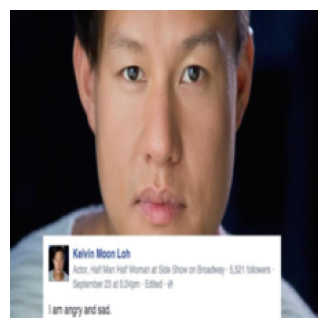

 Generated Caption:   actor writes letter to the autistic child who interrupted his performance actor actor


In [20]:
def generate_caption(image, model):
    
    image = torch.unsqueeze( torch.tensor(image), 0)
    predictions = decoder_tokenizer.decode(model.generate(pixel_values=image.to(device))[0],skip_special_tokens=True)
    caption = predictions.replace(".","") 
    
    image = np.moveaxis(image[0].numpy(),0,-1)
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print( " Generated Caption:  ", caption )
    return caption

pred_caption = generate_caption(image=train_dataset.__getitem__(0)['pixel_values'].numpy(), model=model)

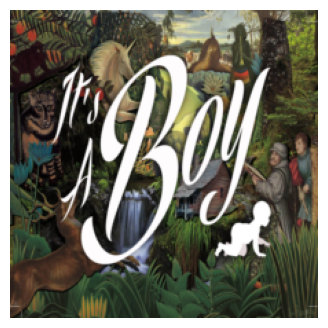

 Generated Caption:   the theme was loosely inspired by nursery the gorgeous men's drawings are just part
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



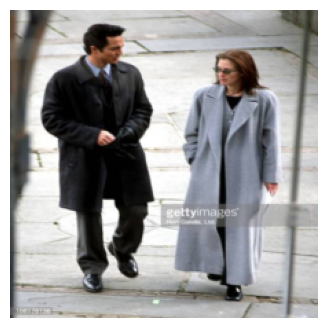

 Generated Caption:   actors on the set of episode entitled actors actors actors on the set actors
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



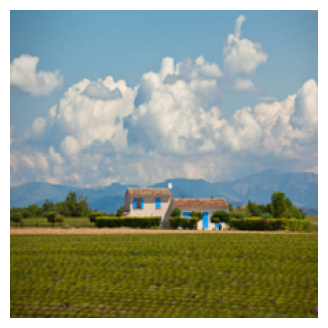

 Generated Caption:   farmhouse in a harvested lavender field farmhouse farmhouse with an ancient barn in the background
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



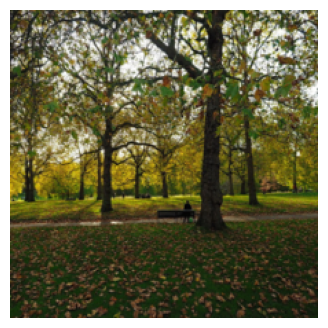

 Generated Caption:   autumn the reds, yellows and browns autumn trees were also a standard color to shine
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



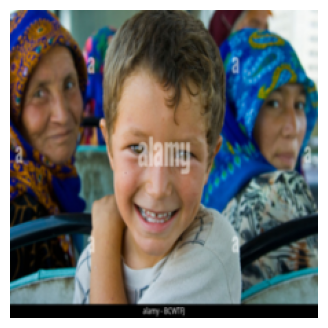

 Generated Caption:   boy in a bus in person boy boy in the parade actor actor in
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



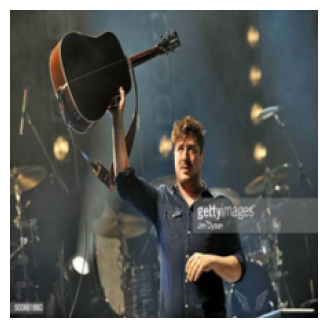

 Generated Caption:   artist of artist performs live on stage artist performs live on stage artist artist
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



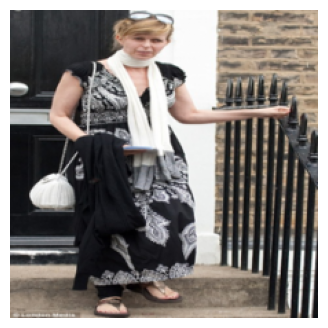

 Generated Caption:   road to recovery : person looked noticeably thinner as she left her home in a black maxi dress
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



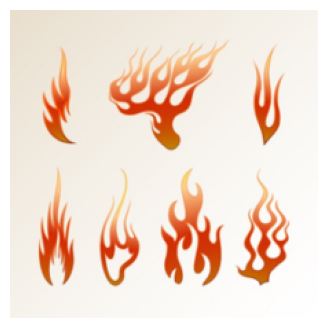

 Generated Caption:   red flame on a light background vector red heart abstract vector abstract time lapse
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



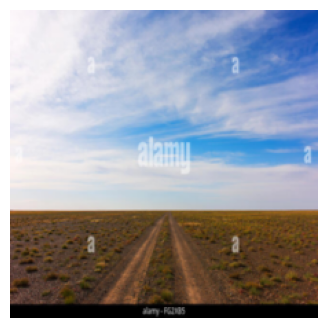

 Generated Caption:   sunny day on the steppe, south sunny day sunny day sunny day sunny
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



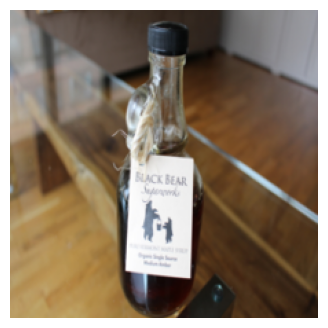

 Generated Caption:   this here is a bottle of pure maple syrup! this used to be a bottle of
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



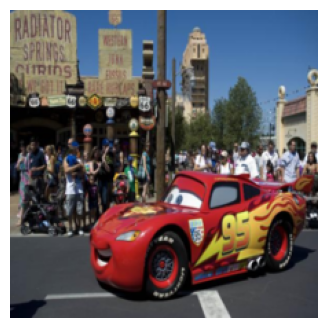

 Generated Caption:   guests watch as film character makes a pass along road and person along tourist
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



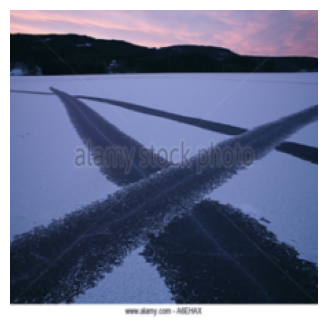

 Generated Caption:   trails in x shape on a frozen lake lake trails in the forest trails
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



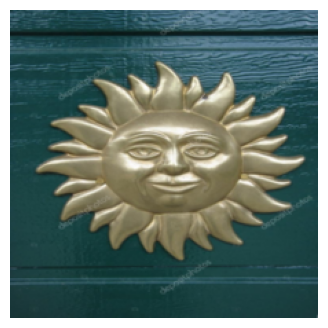

 Generated Caption:   the bas - relief face is hinging on the door, with its intricately carved text
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



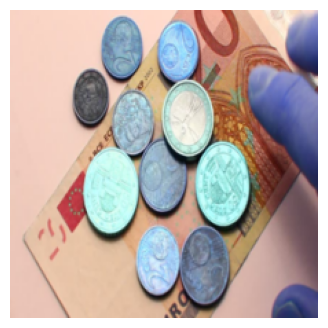

 Generated Caption:   nervous hand and euro coins, paper money on the table i really like the
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



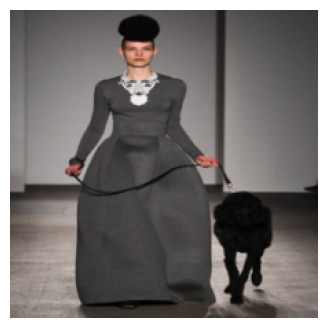

 Generated Caption:   a model walks the runway at the fall fashion show during fashion week fall
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



In [21]:
for index in np.random.randint(int(len(train_dataset)-10),size=15):
    pred_caption = generate_caption( image=train_dataset.__getitem__(int(index))['pixel_values'].numpy(), model=model )
    print( "---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - \n \n" )

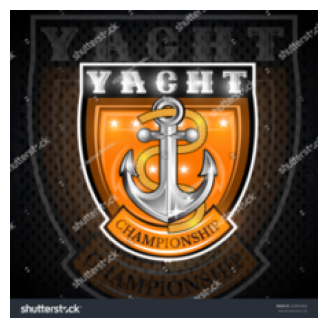

 Generated Caption:   symbol inside a gift box in style symbol of the faith and love of man symbol
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



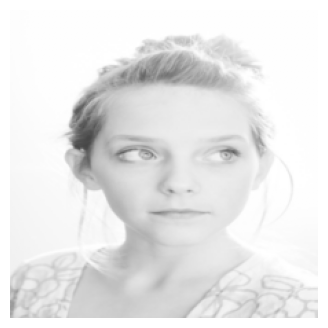

 Generated Caption:   black and white portrait of young girl gazing into the distance, or professional photographer actor
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



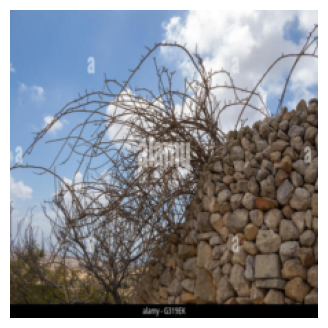

 Generated Caption:   dried wooden gate in spring dry summer dry summer day in the mountains dry pine
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



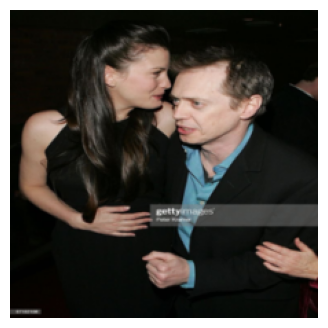

 Generated Caption:   actors greet each other in a press conference actors attend the premiere actors
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



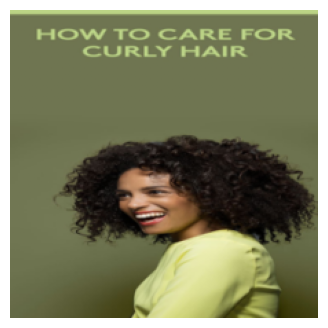

 Generated Caption:   rhythm and blues artist attends the festival's official screening artist is one of the
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



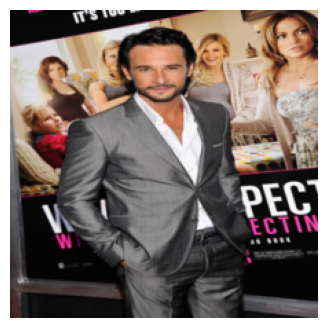

 Generated Caption:   actor at the premiere of thriller film actor is one of many and outnumber
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



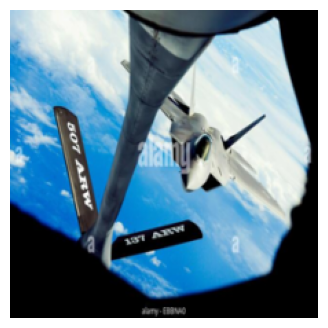

 Generated Caption:   a rocket flying through space the sky the airplane is taking off from the flight deck
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



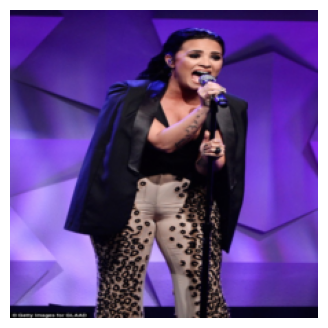

 Generated Caption:   double duty : not only was the singer honoured at the event, she said she was still
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



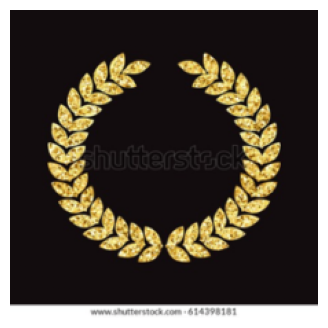

 Generated Caption:   beautiful pair of gold letters m with a pattern realistic letter m with a heart shaped
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



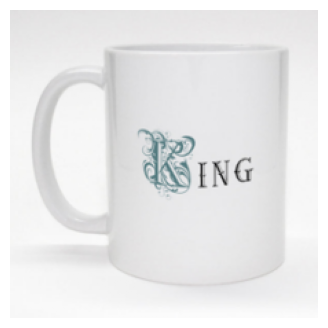

 Generated Caption:   teal and coffee in a mug tea cup tea in the mug
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



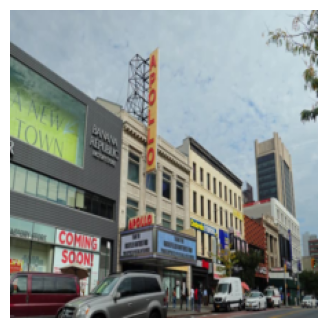

 Generated Caption:   circa a daytime overcast exterior establishing shot where exterior view exterior of the
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



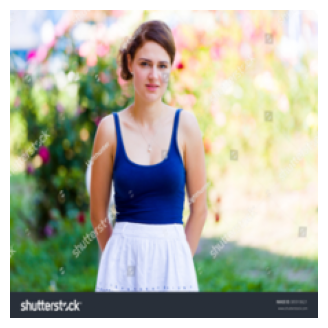

 Generated Caption:   a kind young woman on simple but beautiful clothing in a garden of flowers a kind
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



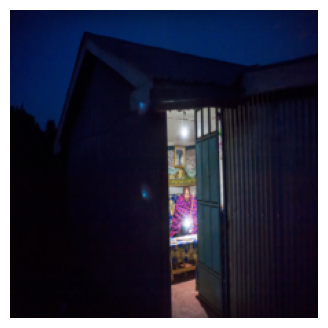

 Generated Caption:   room with a view up to the right twilight over the roof of this house gives
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



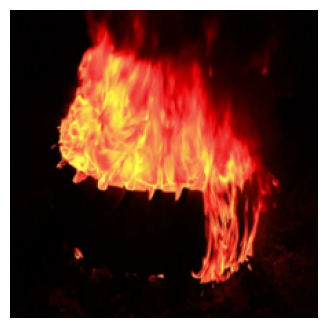

 Generated Caption:   flame of the big fire at night flame flame flame of the big fire
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



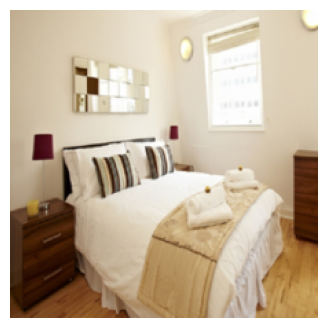

 Generated Caption:   example of a trendy bedroom design with white walls bedroom example of a trendy
---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - 
 



In [22]:
for index in np.random.randint(int(len(val_dataset)-1),size=15):
    pred_caption = generate_caption( image=val_dataset.__getitem__(int(index))['pixel_values'].numpy(), model=model )
    print( "---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - ---- - \n \n" )

In [23]:
print("yo yo signing off . . . . . . . . ")

yo yo signing off . . . . . . . . 


***

# Import Packages